In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2

In [10]:
class CustomLoss(nn.Module):
    def __init__(self,alpha):
        super().__init__()
        self.alpha=alpha
        
    def calculate_distance(self,point1, point2):
        return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)
    
    def divide_into_lanes(self,image):
    # Function to create a folder if it doesn't exist

        # Resize the image to a smaller resolution
        resized_image = cv2.resize(image, (0, 0), fx=0.5, fy=0.5)

        # Convert to grayscale
        gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

        # Perform edge detection
        edges = cv2.Canny(gray, 50, 150)

        # Find contours in the edge-detected image
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Count the number of contours
        num_contours = len(contours)

        print("Number of contours detected:", num_contours)

        # Create a list to store lane images
        lane_images = []

        # Define your color scheme
        colors = [(255, 255, 255), (0, 255, 255), (255, 0, 0), (0, 255, 0),(0, 0, 255)]  # Red, Green, Blue, Yellow, White

        # Iterate through the contours
        for i, contour in enumerate(contours):
            # Filter out contours based on area
            area = cv2.contourArea(contour)
            if area < 1000:  # Adjust the threshold as needed
                continue

            # Create a blank image to draw the filled contour
            filled_lane = np.zeros_like(resized_image)

            # Draw filled contour with a specific color from the color scheme
            cv2.fillPoly(filled_lane, [contour], colors[i % len(colors)])

            # Append the filled lane image to the list
            lane_images.append(filled_lane)

        return lane_images
    
    def calculate_lane_distance(self,lane1, lane2):
        
        gray1 = cv2.cvtColor(lane1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(lane2, cv2.COLOR_BGR2GRAY)
        _, binary1 = cv2.threshold(gray1, 10, 255, cv2.THRESH_BINARY)
        _, binary2 = cv2.threshold(gray2, 10, 255, cv2.THRESH_BINARY)
        
        
        white_pixels1 = np.column_stack(np.where(binary1 != 0))
        white_pixels2 = np.column_stack(np.where(binary2 != 0))
        total_distance = 0
        num_pairs = 0

        for pixel1 in white_pixels1:
            min_distance = float('inf')
            for pixel2 in white_pixels2:
                distance = self.calculate_distance(pixel1, pixel2)
                if distance < min_distance:
                    min_distance = distance
            total_distance += min_distance
            num_pairs += 1
        
        # Calculate average distance
        if num_pairs > 0:
            average_distance = total_distance / num_pairs
        else:
            average_distance = float('inf')
        
        return average_distance
    
    def lossFun(self,pred,GT):
        Pre_lanes= self.divide_into_lanes(pred)
        GT_lanes= self.divide_into_lanes(GT)
        
        loss=0
        
        for i in range(len(GT_lanes)):
            loss+=self.calculate_lane_distance(GT_lanes[i], Pre_lanes[i])
            
        return loss
    
    def forward(self,pred,gt):
        
        res = self.lossFun(pred,gt)
        
        return self.alpha*res
    
    
        
        
    
    
    

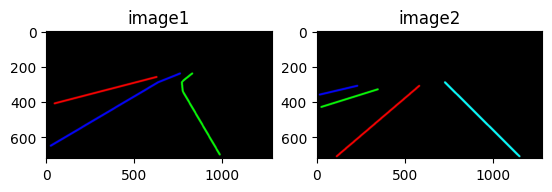

In [11]:
path1="/Users/deepanshubissu/Desktop/DL_Project/Colouring Lanes/tusimple_preprocessed/training/lane-masks/0313-1_60.jpg"
path2="/Users/deepanshubissu/Desktop/DL_Project/Colouring Lanes/tusimple_preprocessed/training/lane-masks/0601_1495492704577874815.jpg"
img1= cv2.imread(path1)
img2= cv2.imread(path2)

plt.subplot(1,2,1)
plt.title("image1")
plt.imshow(img1)
plt.subplot(1,2,2)
plt.title("image2")
plt.imshow(img2)



In [12]:
loss = CustomLoss(alpha=0.5)
print(loss(img1,img2))

Number of contours detected: 3
Number of contours detected: 4
56.14473587772026


In [13]:
loss = CustomLoss(alpha=0.6)
print(loss(img1,img1))

Number of contours detected: 3
Number of contours detected: 3
0.0
